<a href="https://colab.research.google.com/github/synchronizeteam/channa_classification/blob/model_aldy/Copy_of_ResNet_CV_ES_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Deklarasi Requirement

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import io
import gdown

from sklearn.model_selection import StratifiedKFold
from google.colab import drive
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from google.colab import files
from PIL import Image
import os

%matplotlib inline

torch.manual_seed(128)

In [2]:
#Pastiin pake GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. Pengolahan Dataset

In [3]:
# Definisi Kelas
class_names = ['andrao', 'asiatica', 'auranti', 'barca', 'maru', 'stewartii']

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
# Download Datasheet
url = "https://drive.google.com/uc?id=1P1LRTg_UZi8Ns56F8pkB8B0hAEiIwYK6"
output = "datasheet.zip"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1P1LRTg_UZi8Ns56F8pkB8B0hAEiIwYK6
To: /content/datasheet.zip
100%|██████████| 969M/969M [00:14<00:00, 65.0MB/s]


'datasheet.zip'

In [6]:
#ekstrak file
!unzip "/content/datasheet.zip" -d "/content/"

Archive:  /content/datasheet.zip
  inflating: /content/datasheet/barca/barca_75.png  
  inflating: /content/datasheet/barca/barca_82.png  
  inflating: /content/datasheet/barca/barca_85.png  
  inflating: /content/datasheet/barca/barca_97.png  
  inflating: /content/datasheet/barca/barca_31.png  
  inflating: /content/datasheet/barca/barca_81.png  
  inflating: /content/datasheet/barca/barca_96.png  
  inflating: /content/datasheet/barca/barca_80.png  
  inflating: /content/datasheet/barca/barca_77.png  
  inflating: /content/datasheet/barca/barca_87.png  
  inflating: /content/datasheet/barca/barca_89.png  
  inflating: /content/datasheet/barca/barca_11.png  
  inflating: /content/datasheet/barca/barca_79.png  
  inflating: /content/datasheet/barca/barca_95.png  
  inflating: /content/datasheet/barca/barca_93.png  
  inflating: /content/datasheet/barca/barca_36.png  
  inflating: /content/datasheet/barca/barca_72.png  
  inflating: /content/datasheet/barca/barca_73.png  
  inflating: 

In [7]:
#apply pada dataset yg dipakai
dataset = torchvision.datasets.ImageFolder('/content/datasheet', transform=transform)

In [8]:
# Split data train dan val, buat loader
class_indices = {}
for i, (image, label) in enumerate(dataset):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

train_indices = []
val_indices = []

for label in class_indices.keys():
    indices = class_indices[label]
    num_samples = len(indices)
    split = int(0.70 * num_samples)
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

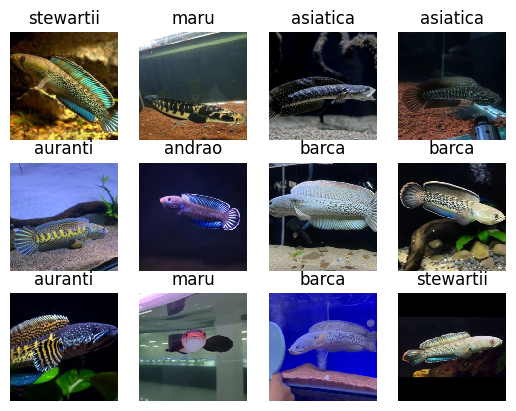

In [9]:
#cek gambar data
images, labels = next(iter(train_loader))

fig = plt.figure()
#plot gambar
for i in range(12):
    img = np.transpose(images[i-1], (1, 2, 0))
    # denormalized_img = (img * 0.5) + 0.5
    plt.subplot(3,4,i+1)
    plt.imshow(img, interpolation='none')
    plt.title(class_names[labels[i-1]])
    plt.axis('off')

plt.show()

# 3. Pembuatan Model

In [10]:
#pakai model Alex yg diatur jumlah layernya
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, num_blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ResNet().to(device)

# 4. Training Data

In [ ]:
#atur loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [26]:
# Define jumlah epoch dan variabel kosong untuk diisi nilai
n_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_correct = 0
    val_loss = 0.0
    val_correct = 0
    
    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            val_correct += (predicted == target).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    # Print the results for this epoch
    print("Epoch {}: loss {:.4f}, accuracy {:.4f}, val_loss {:.4f}, val_accuracy {:.4f}".format(
        epoch+1, train_loss, train_acc, val_loss, val_acc))


Epoch 1: loss 0.7966, accuracy 76.9048, val_loss 2.6251, val_accuracy 38.8889
Epoch 2: loss 0.7336, accuracy 78.5714, val_loss 1.2633, val_accuracy 57.2222
Epoch 3: loss 0.6943, accuracy 77.3810, val_loss 1.7523, val_accuracy 48.3333
Epoch 4: loss 0.7331, accuracy 76.9048, val_loss 1.5128, val_accuracy 54.4444
Epoch 5: loss 0.7733, accuracy 75.2381, val_loss 1.1399, val_accuracy 58.8889
Epoch 6: loss 0.6644, accuracy 79.5238, val_loss 0.9719, val_accuracy 65.5556
Epoch 7: loss 0.6254, accuracy 81.9048, val_loss 0.9592, val_accuracy 64.4444
Epoch 8: loss 0.6382, accuracy 81.6667, val_loss 0.9584, val_accuracy 65.5556
Epoch 9: loss 0.5196, accuracy 85.7143, val_loss 1.1853, val_accuracy 63.8889
Epoch 10: loss 0.4344, accuracy 90.0000, val_loss 1.0412, val_accuracy 62.2222
Epoch 11: loss 0.4215, accuracy 90.2381, val_loss 1.2635, val_accuracy 54.4444
Epoch 12: loss 0.4706, accuracy 86.9048, val_loss 1.1189, val_accuracy 63.3333
Epoch 13: loss 0.4081, accuracy 90.0000, val_loss 2.3752, val

KeyboardInterrupt: ignored

In [27]:
# Menentukan jumlah fold untuk cross-validation
n_splits = 5
num_epochs = 30

# Menyimpan nilai loss dan akurasi dari setiap fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Mengubah dataset menjadi array numpy
data_array = np.array([np.array(image) for image, _ in train_set])
labels = np.array([label for _, label in train_set])

# Membagi data menjadi fold-fold yang sesuai
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=5)

# Melakukan cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(data_array, labels)):
    print(f"Fold {fold+1}/{n_splits}")
    
    # Membagi data menjadi training set dan validation set untuk fold saat ini
    train_set_fold = torch.utils.data.Subset(train_set, train_index.tolist())
    val_set_fold = torch.utils.data.Subset(train_set, val_index.tolist())
    
    # Inisialisasi ulang model untuk setiap fold
    model = ResNet().to(device)
    
    # Menginisialisasi optimizer dan loss function
    optimizer = optim.Adam(
        model.parameters(),
        lr=0.0001           # Laju pembelajaran (learning rate)
    )
    criterion = nn.CrossEntropyLoss()
    
    # Membuat data loader untuk setiap fold
    train_loader_fold = DataLoader(train_set_fold, batch_size=batch_size, shuffle=True)
    val_loader_fold = DataLoader(val_set_fold, batch_size=batch_size)
    
    # Training model pada setiap fold
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Set model ke mode pelatihan
        model.train()
        
        for images, labels in train_loader_fold:
            images = images.to(device)
            labels = labels.to(device)
            
            # Reset gradien parameter
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass dan optimasi
            loss.backward()
            optimizer.step()
            
            # Menghitung loss dan akurasi training
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Menghitung rata-rata loss dan akurasi training
        avg_train_loss = train_loss / train_total
        avg_train_accuracy = (train_correct / train_total) * 100.0
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        
        # Evaluasi model pada validation set
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # Set model ke mode evaluasi (non-pelatihan)
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader_fold:
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Menghitung loss dan akurasi validation
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Menghitung rata-rata loss dan akurasi validation
        avg_val_loss = val_loss / val_total
        avg_val_accuracy = (val_correct / val_total) * 100.0
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        
        # Menampilkan hasil pelatihan untuk setiap epoch
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%")

Fold 1/5
Epoch 1/30: Train Loss: 2.0587, Train Accuracy: 27.98%, Val Loss: 2.4561, Val Accuracy: 16.67%
Epoch 2/30: Train Loss: 1.6275, Train Accuracy: 43.45%, Val Loss: 3.0707, Val Accuracy: 16.67%
Epoch 3/30: Train Loss: 1.3986, Train Accuracy: 50.00%, Val Loss: 3.4959, Val Accuracy: 19.05%
Epoch 4/30: Train Loss: 1.3224, Train Accuracy: 55.95%, Val Loss: 2.3662, Val Accuracy: 21.43%
Epoch 5/30: Train Loss: 1.1784, Train Accuracy: 64.88%, Val Loss: 1.6924, Val Accuracy: 40.48%
Epoch 6/30: Train Loss: 1.0960, Train Accuracy: 65.48%, Val Loss: 2.2271, Val Accuracy: 41.67%
Epoch 7/30: Train Loss: 0.9943, Train Accuracy: 67.86%, Val Loss: 1.5776, Val Accuracy: 55.95%
Epoch 8/30: Train Loss: 0.9126, Train Accuracy: 73.21%, Val Loss: 2.4632, Val Accuracy: 39.29%
Epoch 9/30: Train Loss: 0.9028, Train Accuracy: 72.92%, Val Loss: 1.5466, Val Accuracy: 48.81%
Epoch 10/30: Train Loss: 0.8351, Train Accuracy: 71.73%, Val Loss: 1.5067, Val Accuracy: 53.57%
Epoch 11/30: Train Loss: 0.7556, Train A

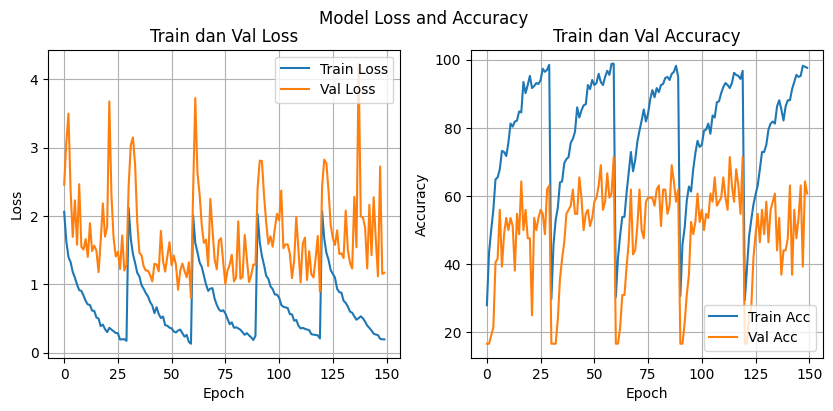

In [28]:
#bikin plot dari hasil training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train dan Val Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc')
ax2.plot(val_accuracies, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train dan Val Accuracy')
ax2.legend()
ax2.grid(True)

fig.suptitle('Model Loss and Accuracy')
plt.show()

# 5. Simpan Model dan Ujicoba

## Save Model

In [29]:
#simpen model
torch.save(model.state_dict(), 'ResNetV3.pt')

## Load Model

In [30]:
#load model
model.load_state_dict(torch.load('ResNetV3.pt'))

<All keys matched successfully>

## Testing  Model

Saving SW1.jpg to SW1.jpg
SW1.jpg
stewartii


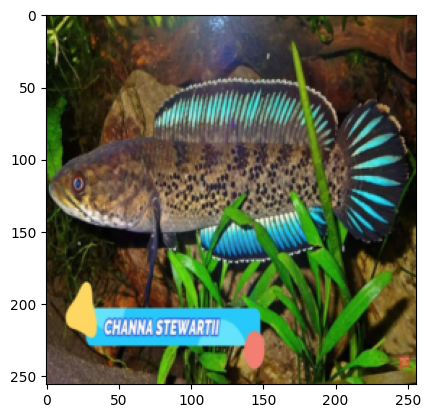

In [36]:
#pengujian model yg dilatih
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = torchvision.transforms.functional.resize(
        torchvision.transforms.functional.to_pil_image(
            np.array(Image.open(io.BytesIO(uploaded[fn])))
        ),
        (256, 256)
    )

    imgplot = plt.imshow(img)
    x = torchvision.transforms.functional.to_tensor(img)
    x = x.unsqueeze(0)
    x = x.to(device)
    
    with torch.no_grad():
        outputs = model(x)
    
    _, preds = torch.max(outputs, 1)
    
    print(fn)
    if preds.item() == 0:
        print('andrao')
    elif preds.item() == 1:
        print('asiatica')
    elif preds.item() == 2:
        print('auranti')
    elif preds.item() == 3:
        print('barca')          
    elif preds.item() == 4:
        print('maru')
    elif preds.item() == 5:
        print('stewartii')
    else:
        print('not detected')
